<a href="https://colab.research.google.com/github/MariuszGrecki/Machine_learning_tutorial/blob/main/regression/04_backward_elimination.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Regresja liniowa - case study

jeżeli mamy kolumnę np. sex female, male nie tworzymy dwóch kolumna tylko jedną sex 0 lub 1, najlepiej używać drop_first=True

✈
**dobieranie danych do modelu**: ELIMINAJCA WSTECZNA
będziemy eliminować pewnie zmienne które nie są miarodajne do oceny modelu, na początku ładujemy wszystkie dane do modelu
1. Wybieramy poziom istotności zmiennej, najczęsciej 0.05
2. Trenujemy model na wszystkich zmiennych objaśniających
3. Sprawdzamy najwyższą wartośc p_value dla zmiennych objaśniających, jeżeli jest wyższa niz 0.05 -> krok 4, przeciwnie -> koniec
4. Usuwa zmienną z najwyższą wartością p_value
5. Trenujemy ponownie model na mniejszej liczbie zmiennych objasniających -> powrót do kroku 3

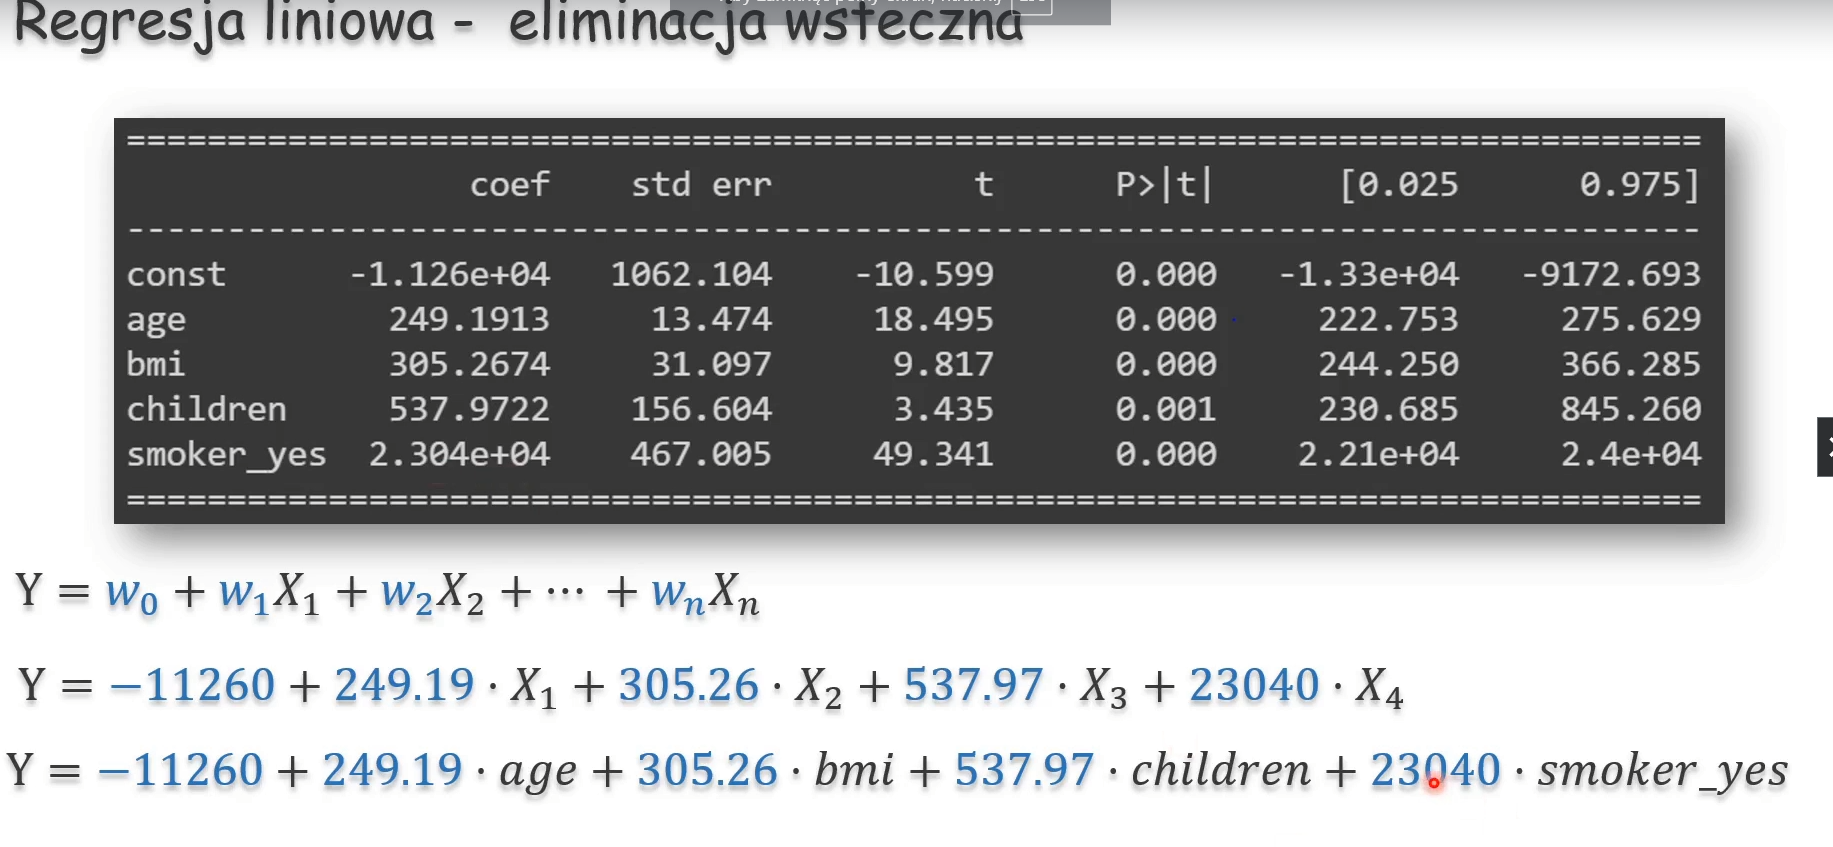


In [2]:
#import bibliotek
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

sns.set()
np.random.seed(42)
np.set_printoptions(precision=4, suppress=True)
sklearn.__version__

'1.2.2'

In [3]:
#wczytywania danych
df_raw = pd.read_csv('https://storage.googleapis.com/esmartdata-courses-files/ml-course/insurance.csv')
df_raw.head()


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
#utworzenie kopii danych
df = df_raw.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
#eksplorcja i wstępne przygotowanie danych
#sprawdzenie czy w danych nie ma duplikatów
df[df.duplicated()]

,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.5631


In [6]:
#wyświetlenie danych gdzie kolumna charges = 1639,5631
df[df['charges'] == 1639.5631]

,age,sex,bmi,children,smoker,region,charges
195,19,male,30.59,0,no,northwest,1639.5631
581,19,male,30.59,0,no,northwest,1639.5631


In [7]:
#usuwamy duplikaty
df = df.drop_duplicates()
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.6+ KB


In [8]:
#zajmujemy się typami zmieniamy object na category / zwracamy nazwy kolumn
cat_cols = [col for col in df.columns if df[col].dtype == 'O']
cat_cols

['sex', 'smoker', 'region']

In [9]:
#zmieniamy na category
for col in cat_cols:
  df[col] = df[col].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       1337 non-null   int64   
 1   sex       1337 non-null   category
 2   bmi       1337 non-null   float64 
 3   children  1337 non-null   int64   
 4   smoker    1337 non-null   category
 5   region    1337 non-null   category
 6   charges   1337 non-null   float64 
dtypes: category(3), float64(2), int64(2)
memory usage: 56.6 KB


<ipython-input-9-83beb7be6b50>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype('category')
<ipython-input-9-83beb7be6b50>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype('category')
<ipython-input-9-83beb7be6b50>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

In [10]:
#wyświetlamy podstawowe statystyki danych
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1337.0,39.222139,14.044333,18.0000,27.000,39.0000,51.00000,64.00000
bmi,1337.0,30.663452,6.100468,15.9600,26.290,30.4000,34.70000,53.13000
children,1337.0,1.095737,1.205571,0.0000,0.000,1.0000,2.00000,5.00000
charges,1337.0,13279.121487,12110.359656,1121.8739,4746.344,9386.1613,16657.71745,63770.42801


In [11]:
df.describe(include=['category']).T

,count,unique,top,freq
sex,1337,2,male,675
smoker,1337,2,no,1063
region,1337,4,southeast,364


In [12]:
#upewniamy się czy nie ma braków danych
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [13]:
#rozkład kategoroo płeć
df.sex.value_counts()

sex
male      675
female    662
Name: count, dtype: int64

In [14]:
df.smoker.value_counts()

smoker
no     1063
yes     274
Name: count, dtype: int64

In [15]:
df.region.value_counts()

region
southeast    364
southwest    325
northeast    324
northwest    324
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

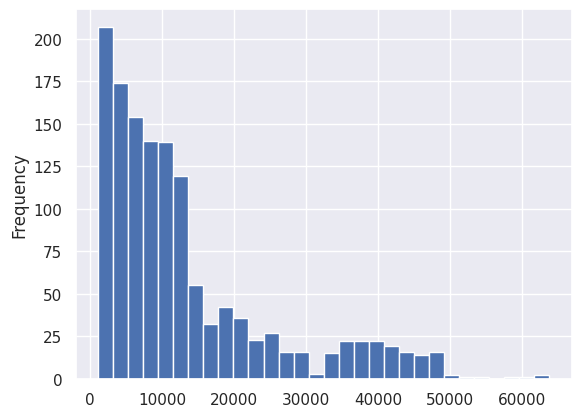

In [16]:
#histogram tej zmiennej
df.charges.plot(kind='hist', bins=30)

In [17]:
#histogram odnośnie opłat w zależności czy dana osoba pali i od płci
import plotly.express as px
px.histogram(df, x='charges', width=700, height=400, nbins=50, facet_col='smoker', facet_row='sex')
# tutaj widzimy że opłaty są większe dla palaczy

In [18]:
#histogram z podziałem na płeć
px.histogram(df, x='smoker', facet_col='sex', color='sex', width=700, height=400)
#tutaj widzimy że więcej facetów pali

In [19]:
#przygotujemy dane do modelu
df_dummies = pd.get_dummies(df, drop_first=True)
df_dummies

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,False,True,False,False,True
1,18,33.770,1,1725.55230,True,False,False,True,False
2,28,33.000,3,4449.46200,True,False,False,True,False
3,33,22.705,0,21984.47061,True,False,True,False,False
4,32,28.880,0,3866.85520,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,10600.54830,True,False,True,False,False
1334,18,31.920,0,2205.98080,False,False,False,False,False
1335,18,36.850,0,1629.83350,False,False,False,True,False
1336,21,25.800,0,2007.94500,False,False,False,False,True


In [20]:
#przygotowujemy korelacje
corr = df_dummies.corr()
corr

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
age,1.000000,0.109344,0.041536,0.298308,-0.019814,-0.025587,0.001495,-0.012311,0.009415
bmi,0.109344,1.000000,0.012755,0.198401,0.046397,0.003746,-0.136138,0.270057,-0.006211
children,0.041536,0.012755,1.000000,0.067389,0.017848,0.007331,0.026044,-0.023492,0.021538
charges,0.298308,0.198401,0.067389,1.000000,0.058044,0.787234,-0.038695,0.073578,-0.043637
sex_male,-0.019814,0.046397,0.017848,0.058044,1.000000,0.076596,-0.012482,0.017578,-0.003767
smoker_yes,-0.025587,0.003746,0.007331,0.787234,0.076596,1.000000,-0.036321,0.068282,-0.037168
region_northwest,0.001495,-0.136138,0.026044,-0.038695,-0.012482,-0.036321,1.000000,-0.345909,-0.320493
region_southeast,-0.012311,0.270057,-0.023492,0.073578,0.017578,0.068282,-0.345909,1.000000,-0.346614
region_southwest,0.009415,-0.006211,0.021538,-0.043637,-0.003767,-0.037168,-0.320493,-0.346614,1.000000


<Axes: >

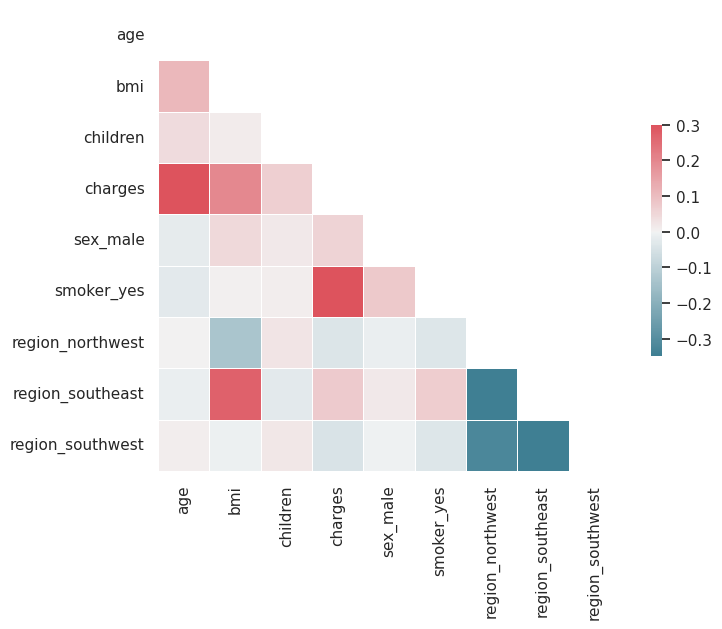

In [21]:
#wyświetlenie danych za pomocą biblioteki cborn jako hitmapa
sns.set(style='white')
mask = np.zeros_like(corr, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(8,6))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [22]:
#sortowanie danych po korelacji
df_dummies.corr()['charges'].sort_values(ascending=False)

charges             1.000000
smoker_yes          0.787234
age                 0.298308
bmi                 0.198401
region_southeast    0.073578
children            0.067389
sex_male            0.058044
region_northwest   -0.038695
region_southwest   -0.043637
Name: charges, dtype: float64

<Axes: >

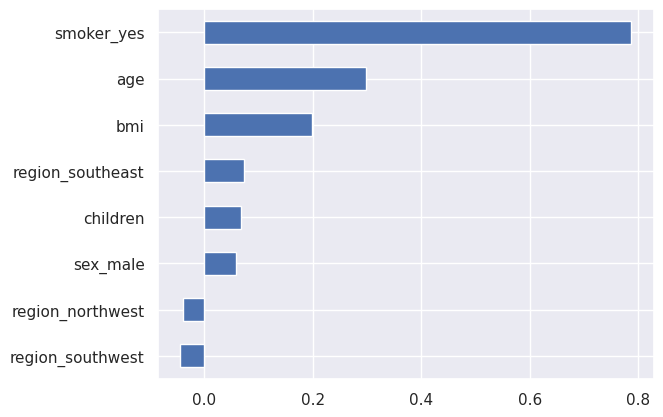

In [23]:
#wyświetlanie prostego wykresu kolumnowego
sns.set()
df_dummies.corr()['charges'].sort_values()[:-1].plot(kind='barh')

In [24]:
#data przygotowane dane
data = df_dummies.copy()
#target czyli nasze charges opłaty wynik
target = data.pop('charges')
data.head()

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,False,True,False,False,True
1,18,33.770,1,True,False,False,True,False
2,28,33.000,3,True,False,False,True,False
3,33,22.705,0,True,False,True,False,False
4,32,28.880,0,True,False,True,False,False


In [25]:
target.head()

0    16884.92400
1     1725.55230
2     4449.46200
3    21984.47061
4     3866.85520
Name: charges, dtype: float64

In [26]:
#Podział danych na zbiór treningowy i testowy
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2)

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (1069, 8)
X_test shape: (268, 8)
y_train shape: (1069,)
y_test shape: (268,)


In [27]:
#Regesja liniowa
from sklearn.linear_model import LinearRegression

#dopasowujemy nasze dane
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [28]:
#Wstępnie wyrzucamy wskaxnik R2
print(f'R2 score: {regressor.score(X_test, y_test):.4f}')

R2 score: 0.8069


In [29]:
#przewidujemy, wyświetlamy 10 pierwszych wartości
y_pred = regressor.predict(X_test)
y_pred[:10]

array([ 8143.6939,  5737.1157, 14369.3149, 31745.5136,  8962.3867,
       13149.7224, 30446.7607,  1453.2888, 10633.0184, 11318.9438])

In [30]:
#
y_true = y_test.copy()
predictions = pd.DataFrame(data={'y_true': y_true, 'y_pred': y_pred})
predictions['error'] = predictions['y_true'] - predictions['y_pred']
predictions.head()

,y_true,y_pred,error
900,8688.85885,8143.693884,545.164966
1064,5708.86700,5737.115683,-28.248683
1256,11436.73815,14369.314876,-2932.576726
298,38746.35510,31745.513636,7000.841464
237,4463.20510,8962.386657,-4499.181557


<Axes: ylabel='Frequency'>

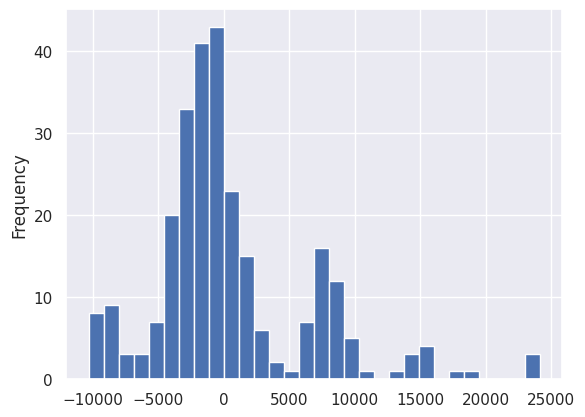

In [31]:
#histogram błędu
predictions.error.plot(kind='hist', bins=30)
#widac ze blad jest czasem wysoki

In [32]:
#inna ocena modelu
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_true, y_pred)
print(f'MAE wynosi: {mae:.2f}')

MAE wynosi: 4177.05


In [33]:
regressor.intercept_

-11092.65229594595

In [34]:
regressor.coef_

array([  248.2107,   318.7014,   533.01  ,  -101.5421, 23077.7646,
        -391.7615,  -838.9196,  -659.1398])

In [35]:
data.columns

Index(['age', 'bmi', 'children', 'sex_male', 'smoker_yes', 'region_northwest',
       'region_southeast', 'region_southwest'],
      dtype='object')

**Eliminacja wsteczna**

In [36]:
#import, pomoże nam jak dobierac konkretne dane
import statsmodels.api as sm

X_train_ols = X_train.copy()
X_train_ols = X_train_ols.values
X_train_ols = sm.add_constant(X_train_ols)
X_train_ols = X_train_ols.astype(int)
X_train_ols

array([[ 1, 23, 24, ...,  0,  0,  0],
       [ 1, 21, 25, ...,  0,  0,  0],
       [ 1, 52, 37, ...,  1,  0,  0],
       ...,
       [ 1, 20, 22, ...,  0,  0,  1],
       [ 1, 38, 28, ...,  0,  0,  1],
       [ 1, 35, 35, ...,  0,  1,  0]])

In [37]:
#regresja liniowa w tej bibliotece
ols = sm.OLS(endog=y_train, exog=X_train_ols).fit()
predictors = ['const'] + list(X_train.columns)
print(ols.summary(xname=predictors))

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     358.0
Date:                Sun, 26 May 2024   Prob (F-statistic):          5.30e-295
Time:                        04:20:09   Log-Likelihood:                -10831.
No. Observations:                1069   AIC:                         2.168e+04
Df Residuals:                    1060   BIC:                         2.172e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.091e+04   1100.397  

In [38]:
#usuwamy sem_male z względu że p jest wyższe niz 0.05
X_selected = X_train_ols[:, [0,1,2,3,5,6,7,8]]
predictors.remove('sex_male')

ols = sm.OLS(endog=y_train, exog=X_selected).fit()
print(ols.summary(xname=predictors))

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     409.5
Date:                Sun, 26 May 2024   Prob (F-statistic):          2.62e-296
Time:                        04:20:09   Log-Likelihood:                -10831.
No. Observations:                1069   AIC:                         2.168e+04
Df Residuals:                    1061   BIC:                         2.172e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.095e+04   1088.657  

In [39]:
#usuwamy regiond_northwest z względu że p jest wyższe niz 0.05
X_selected = X_train_ols[:, [0,1,2,3,5,7,8]]
predictors.remove('region_northwest')

ols = sm.OLS(endog=y_train, exog=X_selected).fit()
print(ols.summary(xname=predictors))

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     477.9
Date:                Sun, 26 May 2024   Prob (F-statistic):          1.49e-297
Time:                        04:20:09   Log-Likelihood:                -10831.
No. Observations:                1069   AIC:                         2.168e+04
Df Residuals:                    1062   BIC:                         2.171e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.114e+04   1057.622  

In [40]:
#usuwamy regiond_southeast z względu że p jest wyższe niz 0.05
X_selected = X_train_ols[:, [0,1,2,3,5,8]]
predictors.remove('region_southeast')

ols = sm.OLS(endog=y_train, exog=X_selected).fit()
print(ols.summary(xname=predictors))

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     572.6
Date:                Sun, 26 May 2024   Prob (F-statistic):          1.53e-298
Time:                        04:20:09   Log-Likelihood:                -10832.
No. Observations:                1069   AIC:                         2.168e+04
Df Residuals:                    1063   BIC:                         2.171e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.101e+04   1054.079  

In [41]:
#usuwamy regiond_soutwest z względu że p jest wyższe niz 0.05
X_selected = X_train_ols[:, [0,1,2,3,5]]
predictors.remove('region_southwest')

ols = sm.OLS(endog=y_train, exog=X_selected).fit()
print(ols.summary(xname=predictors))

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     716.1
Date:                Sun, 26 May 2024   Prob (F-statistic):          6.30e-300
Time:                        04:20:10   Log-Likelihood:                -10832.
No. Observations:                1069   AIC:                         2.167e+04
Df Residuals:                    1064   BIC:                         2.170e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.107e+04   1047.721    -10.570      0.0

Eliminacja wsteczna - automatyzacja

In [43]:
X_train_numpy = X_train.values
X_train_numpy = sm.add_constant(X_train_numpy)
X_train_numpy = X_train_numpy.astype(int)

num_vars = len(X_train_numpy[0])

predictors = ['const'] + list(X_train.columns)
sl = 0.05

for i in range(0, num_vars):
  ols = sm.OLS(endog=y_train, exog=X_train_numpy).fit()
  max_pval = max(ols.pvalues.astype('float'))
  if max_pval > sl:
    for j in range(0, num_vars - i):
      if ols.pvalues[j].astype('float') == max_pval:
        X_train_numpy = np.delete(X_train_numpy, j, axis=1)
        predictors.remove(predictors[j])

print(ols.summary(xname=predictors))

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     716.1
Date:                Sun, 26 May 2024   Prob (F-statistic):          6.30e-300
Time:                        04:21:16   Log-Likelihood:                -10832.
No. Observations:                1069   AIC:                         2.167e+04
Df Residuals:                    1064   BIC:                         2.170e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.107e+04   1047.721    -10.570      0.0

In [44]:
#zapisanie końcowego modelu
ols.save('model.pickle')